In [1]:
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import skimage
import PIL

In [2]:
plt.rcParams['figure.figsize'] = (16, 9)

In [3]:
butterfly = plt.imread('butterfly.jpg')

In [4]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray/255

In [5]:
butterfly_gray = rgb2gray(butterfly)

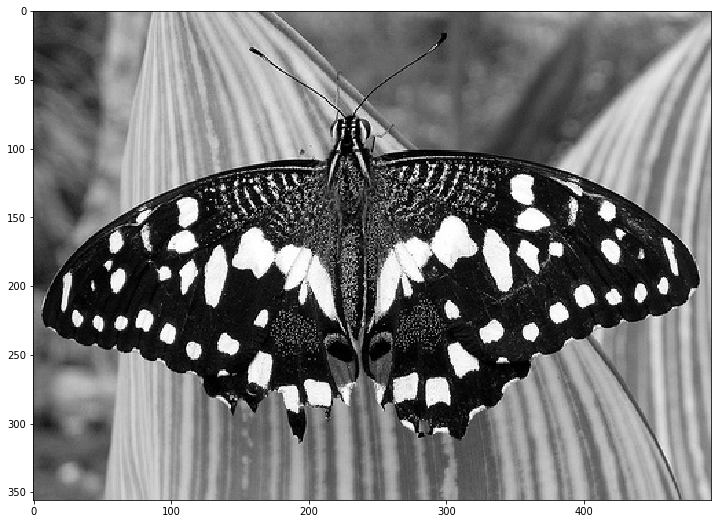

In [6]:
plt.imshow(butterfly_gray,cmap='gray')
plt.show()

In [7]:
print('image max pixel = ',np.max(butterfly_gray))
print('image min pixel = ',np.min(butterfly_gray))
print('image shape = ', np.shape(butterfly_gray
                                ))

image max pixel =  0.9998999999999999
image min pixel =  0.0
image shape =  (356, 493)


In [8]:
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import time

In [9]:
def show_all_circles(image, cx, cy, rad, color='r'):
    """
    image: numpy array, representing the grayscsale image
    cx, cy: numpy arrays or lists, centers of the detected blobs
    rad: numpy array or list, radius of the detected blobs
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')
    for x, y, r in zip(cx, cy, rad):
        circ = Circle((x, y), r, color=color, fill=False)
        ax.add_patch(circ)

    plt.title('%i circles' % len(cx))
    plt.show()

In [10]:
import numpy as np
from scipy.ndimage import gaussian_filter, gaussian_laplace
import math
from math import sqrt, log
from scipy import spatial
def _compute_disk_overlap(d, r1, r2):
    """
    Compute fraction of surface overlap between two disks of radii
    ``r1`` and ``r2``, with centers separated by a distance ``d``.
    Parameters
    ----------
    d : float
        Distance between centers.
    r1 : float
        Radius of the first disk.
    r2 : float
        Radius of the second disk.
    Returns
    -------
    fraction: float
        Fraction of area of the overlap between the two disks.
    """

    ratio1 = (d ** 2 + r1 ** 2 - r2 ** 2) / (2 * d * r1)
    ratio1 = np.clip(ratio1, -1, 1)
    acos1 = math.acos(ratio1)

    ratio2 = (d ** 2 + r2 ** 2 - r1 ** 2) / (2 * d * r2)
    ratio2 = np.clip(ratio2, -1, 1)
    acos2 = math.acos(ratio2)

    a = -d + r2 + r1
    b = d - r2 + r1
    c = d + r2 - r1
    d = d + r2 + r1
    area = (r1 ** 2 * acos1 + r2 ** 2 * acos2 -
            0.5 * sqrt(abs(a * b * c * d)))
    return area / (math.pi * (min(r1, r2) ** 2))


def _compute_sphere_overlap(d, r1, r2):
    """
    Compute volume overlap fraction between two spheres of radii
    ``r1`` and ``r2``, with centers separated by a distance ``d``.
    Parameters
    ----------
    d : float
        Distance between centers.
    r1 : float
        Radius of the first sphere.
    r2 : float
        Radius of the second sphere.
    Returns
    -------
    fraction: float
        Fraction of volume of the overlap between the two spheres.
    Notes
    -----
    See for example http://mathworld.wolfram.com/Sphere-SphereIntersection.html
    for more details.
    """
    vol = (math.pi / (12 * d) * (r1 + r2 - d)**2 *
           (d**2 + 2 * d * (r1 + r2) - 3 * (r1**2 + r2**2) + 6 * r1 * r2))
    return vol / (4./3 * math.pi * min(r1, r2) ** 3)


def _blob_overlap(blob1, blob2):
    """Finds the overlapping area fraction between two blobs.
    Returns a float representing fraction of overlapped area.
    Parameters
    ----------
    blob1 : sequence of arrays
        A sequence of ``(row, col, sigma)`` or ``(pln, row, col, sigma)``,
        where ``row, col`` (or ``(pln, row, col)``) are coordinates
        of blob and ``sigma`` is the standard deviation of the Gaussian kernel
        which detected the blob.
    blob2 : sequence of arrays
        A sequence of ``(row, col, sigma)`` or ``(pln, row, col, sigma)``,
        where ``row, col`` (or ``(pln, row, col)``) are coordinates
        of blob and ``sigma`` is the standard deviation of the Gaussian kernel
        which detected the blob.
    Returns
    -------
    f : float
        Fraction of overlapped area (or volume in 3D).
    """
    n_dim = len(blob1) - 1
    root_ndim = sqrt(n_dim)

    # extent of the blob is given by sqrt(2)*scale
    r1 = blob1[-1] * root_ndim
    r2 = blob2[-1] * root_ndim

    d = sqrt(np.sum((blob1[:-1] - blob2[:-1])**2))
    if d > r1 + r2:
        return 0

    # one blob is inside the other, the smaller blob must die
    if d <= abs(r1 - r2):
        return 1

    if n_dim == 2:
        return _compute_disk_overlap(d, r1, r2)

    else:  # http://mathworld.wolfram.com/Sphere-SphereIntersection.html
        return _compute_sphere_overlap(d, r1, r2)
def _prune_blobs(blobs_array, overlap):
    """Eliminated blobs with area overlap.
    Parameters
    ----------
    blobs_array : ndarray
        A 2d array with each row representing 3 (or 4) values,
        ``(row, col, sigma)`` or ``(pln, row, col, sigma)`` in 3D,
        where ``(row, col)`` (``(pln, row, col)``) are coordinates of the blob
        and ``sigma`` is the standard deviation of the Gaussian kernel which
        detected the blob.
        This array must not have a dimension of size 0.
    overlap : float
        A value between 0 and 1. If the fraction of area overlapping for 2
        blobs is greater than `overlap` the smaller blob is eliminated.
    Returns
    -------
    A : ndarray
        `array` with overlapping blobs removed.
    """
    sigma = blobs_array[:, -1].max()
    distance = 2 * sigma * sqrt(blobs_array.shape[1] - 1)
    tree = spatial.cKDTree(blobs_array[:, :-1])
    pairs = np.array(list(tree.query_pairs(distance)))
    if len(pairs) == 0:
        return blobs_array
    else:
        for (i, j) in pairs:
            blob1, blob2 = blobs_array[i], blobs_array[j]
            if _blob_overlap(blob1, blob2) > overlap:
                if blob1[-1] > blob2[-1]:
                    blob2[-1] = 0
                else:
                    blob1[-1] = 0

    return np.array([b for b in blobs_array if b[-1] > 0])


In [11]:
def blob_detection(image,min_sigma = 1, num_sigma = 10,scale_factor = 3,
                    threshold = 0.05, remove_overlap = False, overlap = 0.5):
    if len(np.shape(image)) == 3:
        image = rgb2gray(image)
    h,w = np.shape(image)
    sigma_list = np.arange(num_sigma)*scale_factor
    sigma_list[0] = 1
    scale_space = np.empty((h,w,num_sigma))
    # [h,w] - dimensions of image, n - number of levels in scale space
    for i in range(len(sigma_list)):
        sigma = sigma_list[i]
        temp = -scipy.ndimage.gaussian_laplace(image,sigma)*sigma**2
        #temp = temp**2
        scale_space[:,:,i] = temp # store a matrix at level i
    temp_scale_space = scipy.ndimage.rank_filter(scale_space,-1,size = 3)
    temp_scale_space = np.where(temp_scale_space<threshold,0,temp_scale_space)
    local_max = np.argwhere(temp_scale_space == scale_space)
    sigmas_of_peaks = sigma_list[local_max[:, -1]]
    sigmas_of_peaks = sigmas_of_peaks[:,np.newaxis]
    local_max = np.hstack([local_max[:, :-1], sigmas_of_peaks])
    if remove_overlap:
        local_max = _prune_blobs(local_max,overlap)
    return local_max[:,1], local_max[:,0], local_max[:,2]*np.sqrt(2)

In [12]:
def blob_detection_efficient(image,num_sigma = 10, scale_factor = 3,
                             threshold = 0.05, remove_overlap = False, overlap = 0.5):
    if len(np.shape(image)) == 3:
        image = rgb2gray(image)
    h,w = np.shape(image)
    sigma_list = np.arange(num_sigma)*scale_factor
    sigma_list[0] = 1
    scale_space = np.empty((h,w,num_sigma))
    # [h,w] - dimensions of image, n - number of levels in scale space
    scale_space[:,:,0] = -scipy.ndimage.gaussian_laplace(image,1)
    for i in range(1,num_sigma):
        sigma = sigma_list[i]//scale_factor
        temp = resize(image,(h//scale_factor,w//scale_factor))
        temp = -scipy.ndimage.gaussian_laplace(temp,sigma)*sigma**2
        temp = resize(temp,(h,w))
        #temp = temp**2
        scale_space[:,:,i] = temp # store a matrix at level i
    scale_space = scale_space[:,:,1:]
    temp_scale_space = scipy.ndimage.rank_filter(scale_space,-1,size = 3)
    temp_scale_space = np.where(temp_scale_space<threshold,0,temp_scale_space)
    local_max = np.argwhere(temp_scale_space == scale_space)
    sigmas_of_peaks = sigma_list[local_max[:, -1]+1]
    sigmas_of_peaks = sigmas_of_peaks[:,np.newaxis]
    local_max = np.hstack([local_max[:, :-1], sigmas_of_peaks])
    if remove_overlap:
        local_max = _prune_blobs(local_max,overlap)
    return local_max[:,1], local_max[:,0], local_max[:,2]*np.sqrt(2)

In [13]:
start = time.time()
cx,cy,rad = blob_detection(butterfly_gray,scale_factor=2,num_sigma=7,threshold=0.03,remove_overlap=False)
end = time.time()
print('simple time = ',end-start)

simple time =  0.33130383491516113


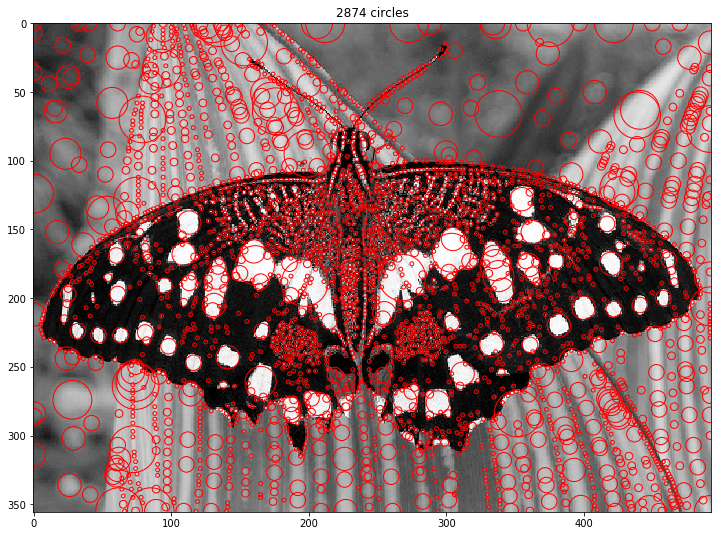

In [14]:
show_all_circles(butterfly_gray, cx, cy, rad, color='r')

In [15]:
start = time.time()
cx,cy,rad = blob_detection_efficient(butterfly_gray,scale_factor=2,num_sigma=7,threshold=0.07,remove_overlap=False)
end = time.time()
print('efficient time = ',end-start)

efficient time =  0.17433595657348633


/Users/mac/anaconda3/envs/py3_5/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/mac/anaconda3/envs/py3_5/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


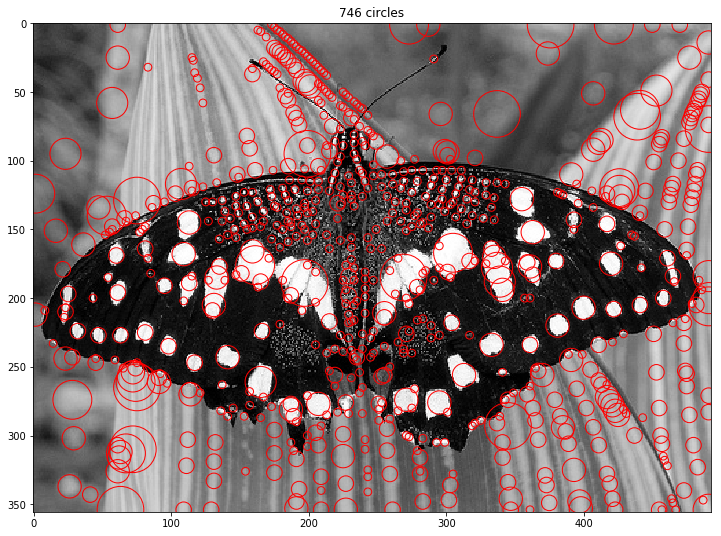

In [16]:
show_all_circles(butterfly_gray, cx, cy, rad, color='r')

In [17]:
einstein =  plt.imread('einstein.jpg')
einstein_gray = rgb2gray(einstein)

In [ ]:
start = time.time()
cx1,cy1,rad1 = blob_detection(einstein_gray,scale_factor=2,num_sigma=7,threshold=0.05)
end = time.time()
print('simple time = ',end-start)

In [18]:
temp_image = plt.imread('./Predict_2Te_20190525_03571501_RR_2257_10frame.tif')
large_label = temp_image[:,:,0]

In [47]:
start = time.time()
cx1,cy1,rad1 = blob_detection(large_label,scale_factor=1,num_sigma=2,threshold=0.05)
end = time.time()
print('simple time = ',end-start)

simple time =  0.34894490242004395


In [49]:
len(cx1)

2097152

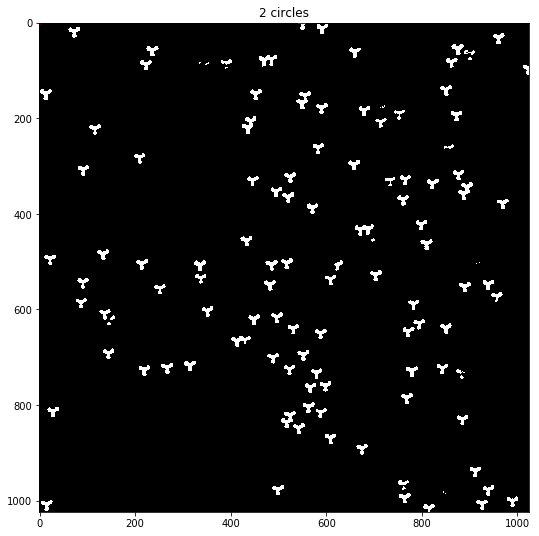

In [46]:
show_all_circles(large_label,cx1[:2],cy1[:2],rad1[:2],color='r')

In [ ]:
start = time.time()
cx11,cy11,rad11 = blob_detection_efficient(einstein_gray,scale_factor=2,num_sigma=7,threshold=0.05)
end = time.time()
print('efficient time = ',end-start)

In [ ]:
show_all_circles(einstein_gray,cx11,cy11,rad11,color='r')

In [ ]:
fishes = plt.imread('fishes.jpg')
fishes_gray = rgb2gray(fishes)

In [ ]:
start = time.time()
cx2,cy2,rad2 = blob_detection(fishes,scale_factor=1.5,num_sigma=7,threshold=0.02)
end = time.time()
print('simple time = ',end-start)

In [ ]:
show_all_circles(fishes_gray,cx2,cy2,rad2,color='r')

In [ ]:
start = time.time()
cx21,cy21,rad21 = blob_detection_efficient(fishes_gray,scale_factor=1.5,num_sigma=7,threshold=0.02)
end = time.time()
print('efficient time = ',end-start)

In [ ]:
show_all_circles(fishes_gray,cx21,cy21,rad21,color='r')

In [ ]:
sunflowers = plt.imread('sunflowers.jpg')
sunflowers_gray = rgb2gray(sunflowers)

In [ ]:
start = time.time()
cx3,cy3,rad3 = blob_detection(sunflowers_gray,scale_factor=2.5,num_sigma=10,threshold=0.07)
end = time.time()
print('simple time = ',end-start)

In [ ]:
show_all_circles(sunflowers_gray,cx3,cy3,rad3,color='r')

In [ ]:
start = time.time()
cx31,cy31,rad31 = blob_detection_efficient(sunflowers_gray,scale_factor=2.5,num_sigma=10,threshold=0.07)
end = time.time()
print('efficient time = ',end-start)

In [ ]:
show_all_circles(sunflowers_gray,cx3,cy3,rad3,color='r')

In [ ]:
atom = plt.imread('2319 HAADF 4.6 Mx HAADF.tif')/255

In [ ]:
start = time.time()
cx41,cy41,rad41 = blob_detection(atom,scale_factor=3,num_sigma=4,threshold=0.07,remove_overlap=True)
end = time.time()
print('simple time = ',end-start)

In [ ]:
start = time.time()
cx41,cy41,rad41 = blob_detection_efficient(atom,scale_factor=3,num_sigma=4,threshold=0.07,remove_overlap=True)
end = time.time()
print('efficient time = ',end-start)

In [ ]:
show_all_circles(atom,cx41,cy41,rad41,color='r')

In [ ]:
arthur1 = plt.imread('1.jpg')
arthur1_gray = rgb2gray(arthur1)

In [ ]:
start = time.time()
cx41,cy41,rad41 = blob_detection(arthur1_gray,scale_factor=5,num_sigma=8,threshold=0.03)
end = time.time()
print('simple time = ',end-start)

In [ ]:
start = time.time()
cx41,cy41,rad41 = blob_detection_efficient(arthur1_gray,scale_factor=5,num_sigma=8,threshold=0.03)
end = time.time()
print('efficient time = ',end-start)

In [ ]:
show_all_circles(arthur1_gray,cx41,cy41,rad41,color='r')

In [ ]:
arthur2 = plt.imread('2.jpg')
arthur2_gray = rgb2gray(arthur2)

In [ ]:
start = time.time()
cx41,cy41,rad41 = blob_detection(arthur2_gray,scale_factor=5,num_sigma=8,threshold=0.03)
end = time.time()
print('simple time = ',end-start)

In [ ]:
start = time.time()
cx41,cy41,rad41 = blob_detection_efficient(arthur2_gray,scale_factor=5,num_sigma=8,threshold=0.03)
end = time.time()
print('efficient time = ',end-start)

In [ ]:
show_all_circles(arthur2_gray,cx41,cy41,rad41,color='r')

In [ ]:
arthur3 = plt.imread('3.jpg')
arthur3_gray = rgb2gray(arthur3)

In [ ]:
start = time.time()
cx41,cy41,rad41 = blob_detection(arthur3_gray,scale_factor=5,num_sigma=8,threshold=0.03)
end = time.time()
print('simple time = ',end-start)

In [ ]:
start = time.time()
cx41,cy41,rad41 = blob_detection_efficient(arthur3_gray,scale_factor=2,num_sigma=8,threshold=0.03)
end = time.time()
print('efficient time = ',end-start)

In [ ]:
show_all_circles(arthur3_gray,cx41,cy41,rad41,color='r')